In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [13]:
parser = argparse.ArgumentParser(description='Pre_train MNIST Example')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=20, metavar='N',
#                     help='how many batches to wait before logging training status')
parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=4,help='num class')

parser.add_argument('--mlp-dim', type=int, default=200, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [8]:
#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all=[]

for i in [1,2,3,5,7,9]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)
# data_whole=data_whole.reshape(-1,2,10,10)


The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

Tc=19

Phase_label_1=[]

[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_1))

Tc=22

Phase_label_2=[]

[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_2))


Tc=26

Phase_label_3=[]

[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_3))

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all=[]
for i in range(data_whole.shape[0]):#
    data_all.append([data_whole[i], Phase_label[i]])

print(len(data_all))

(6, 35, 500, 2, 20, 20)
35000
35000
35000
(105000,)
torch.Size([105000, 2, 20, 20])
torch.Size([105000])
105000


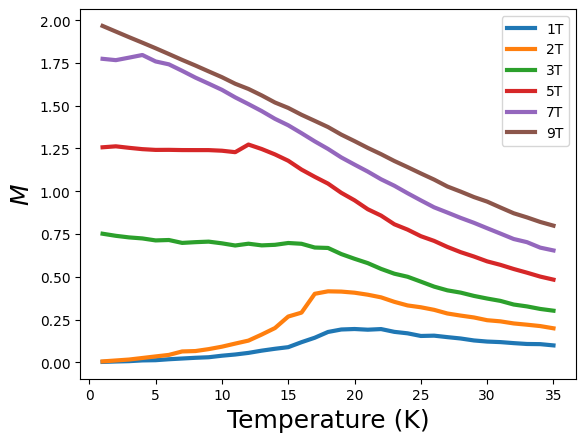

In [9]:
for i, j in zip(range(len(M_raw_all)),[1,2,3,5,7,9]) :

    plt.plot(T,M_raw_all[i],label='{}T'.format(j),lw=3)


plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


# plt.text(25,0.05,'Training dataset',fontsize=16)
# plt.text(5,0.30,'Training dataset',fontsize=16)


plt.legend()
plt.show()

In [10]:
#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all_test=[]

for i in [1.5, 4, 8]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all_test.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)

The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

Tc=19
Phase_label_1=[]
[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=22
Phase_label_2=[]
[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=26
Phase_label_3=[]
[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3)  for i in range(len(T)) for j in range(The_shape[2])]

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all_test=[]
for i in range(data_whole.shape[0]):#
    data_all_test.append([data_whole[i], Phase_label[i]])

print(len(data_all_test))



(3, 35, 500, 2, 20, 20)
(52500,)
torch.Size([52500, 2, 20, 20])
torch.Size([52500])
52500


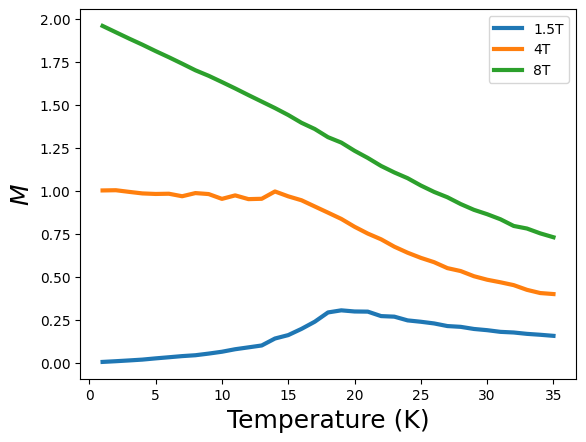

In [11]:
for i, j in zip(range(len(M_raw_all_test)),[1.5, 4, 8]) :

    plt.plot(T,M_raw_all_test[i],label='{}T'.format(j),lw=3)

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.legend()
plt.show()

In [12]:
train_loader = DataLoader(data_all, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_all_test, batch_size = args.batch_size, shuffle=True )

# shuffled_indices = np.random.permutation(len(data_all))
# train_idx = shuffled_indices[:int(0.8*len(data_all))]
# val_idx = shuffled_indices[int(0.8*len(data_all)):]

# train_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

In [14]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, h_dim=500, class_num=2,dropout_rate=0.1):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.convseq = nn.Sequential(

            nn.Conv2d(args.channels, 28 , kernel_size=(args.imgage_patch,args.imgage_patch), stride=(args.imgage_patch,args.imgage_patch) ),
            nn.BatchNorm2d(28),
            nn.Dropout(p=dropout_rate),
            
            nn.LeakyReLU(),#8*8
            # nn.GELU(),

            # nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1) ),
            # # nn.BatchNorm2d(32),
            # nn.Dropout(p=dropout_rate),
            
            # nn.LeakyReLU(),#6*6
            # nn.GELU(),


        )

        self.dense = nn.Sequential(
            nn.Linear(28*int(args.imgage_size/args.imgage_patch)**2, h_dim),
            nn.Dropout(p=dropout_rate),

            nn.LeakyReLU(),  
            # nn.ReLU(),           
            # nn.LayerNorm(h_dim),
            nn.BatchNorm1d(h_dim),
            
            nn.Linear(h_dim, class_num),
            # nn.Sigmoid()
            # nn.Softmax()

        )
        
    
    
    def forward(self, inputs):
        
        outputs = self.convseq(inputs)
        outputs = outputs.view(outputs.size(0), -1)  #or use [ outputs.size(0), ]
        outputs = self.dense(outputs)
        return outputs
    

def Train_model(model, optimizer, data_loader, loss_history,epoch):
    model.train()
    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)

    The_loss=0

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)

        # output = F.log_softmax(model(data), dim=1)
        # loss = F.nll_loss(output, target)
        loss_f = nn.CrossEntropyLoss()
        loss = loss_f(model.forward(data), target)

        The_loss+=loss.detach().item()

        loss.backward()
        optimizer.step()

    loss_history.append(The_loss/len(data_loader))#loss.item()

    if epoch % 10==0 or epoch<=5:
        print('Epoch {}: Average train loss : {:.5f}'.format(epoch,The_loss/len(data_loader)))

def evaluate(model, data_loader, loss_history,Accuracy_rate,epoch):
    model.eval()

    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data=data.to(device)
            target=target.to(device)
            ###
            # output = F.log_softmax(model(data), dim=1)
            # loss = F.nll_loss(output, target, reduction='sum')
            loss_f = nn.CrossEntropyLoss()
            loss = loss_f(model(data),target)

            # _, pred = torch.max(output, dim=0)#

            total_loss += loss.item()
            # correct_samples += pred.eq(target).sum()
            ###
            output_f=nn.Softmax(dim=-1)
            predicted = output_f(model.forward(data)).argmax(dim=-1)

            # total += target.size(0)
            correct_samples += predicted.eq(target).sum().item()


    avg_loss = total_loss / len(data_loader)#total_samples
    loss_history.append(avg_loss)
    Accuracy = 100.0 * correct_samples / total_samples
    Accuracy_rate.append(Accuracy)

    if epoch % 10 ==0 or epoch<=5:

        print('Epoch {}: '.format(epoch)+'Average test loss: ' + '{:.5f}'.format(avg_loss) +
            '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
            '{:5}'.format(total_samples) + ' (' +
            '{:4.2f}'.format(Accuracy) + '%)\n')



In [19]:
%%time

model_D = Discriminator( h_dim=args.mlp_dim, class_num=args.num_class,dropout_rate=0.4)#args.dropout_rate

model_D.to(device)
optimizer = optim.Adam(model_D.parameters(), lr=args.learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range(1, args.epochs + 1):#1000+1
    # print('Epoch:', epoch)
    Train_model(model_D, optimizer, train_loader, train_loss_history,epoch)
    evaluate(model_D, test_loader, test_loss_history,Accuracy_rate,epoch)

Epoch 1: Average train loss : 0.52359
Epoch 1: Average test loss: 0.48700  Accuracy:38920/52500 (74.13%)

Epoch 2: Average train loss : 0.39588
Epoch 2: Average test loss: 0.25429  Accuracy:48027/52500 (91.48%)

Epoch 3: Average train loss : 0.34814
Epoch 3: Average test loss: 0.22249  Accuracy:48644/52500 (92.66%)

Epoch 4: Average train loss : 0.32328
Epoch 4: Average test loss: 0.21233  Accuracy:48726/52500 (92.81%)

Epoch 5: Average train loss : 0.31022
Epoch 5: Average test loss: 0.19774  Accuracy:49048/52500 (93.42%)

Epoch 10: Average train loss : 0.27349
Epoch 10: Average test loss: 0.20011  Accuracy:48547/52500 (92.47%)

Epoch 20: Average train loss : 0.23877
Epoch 20: Average test loss: 0.17731  Accuracy:49167/52500 (93.65%)

Epoch 30: Average train loss : 0.22158
Epoch 30: Average test loss: 0.18446  Accuracy:48846/52500 (93.04%)

Epoch 40: Average train loss : 0.20882
Epoch 40: Average test loss: 0.17934  Accuracy:48989/52500 (93.31%)

Epoch 50: Average train loss : 0.20136

In [20]:
model_D

Discriminator(
  (convseq): Sequential(
    (0): Conv2d(2, 28, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (dense): Sequential(
    (0): Linear(in_features=700, out_features=200, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=200, out_features=4, bias=True)
  )
)

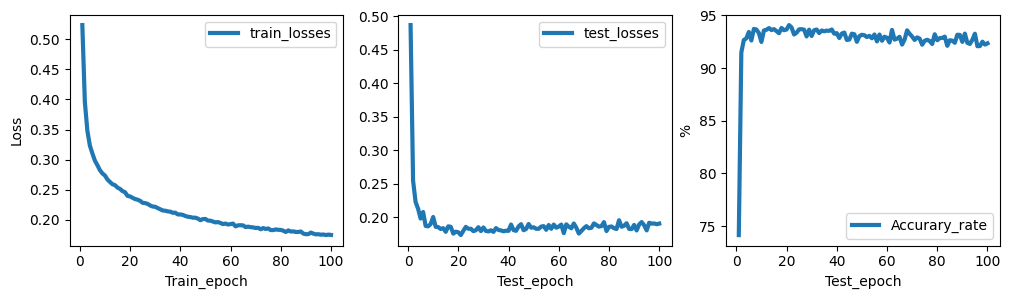

In [21]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()


ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [44]:
# for i in range(0,20000,500):
#     A_test=data_all_test[i:i+500]
#     model_D.eval()
#     all=0
#     with torch.no_grad():
#         for img ,label in A_test:
#             img=img.cuda()
#             img=img.view(-1,2,20,20)
#             A=nn.Softmax(dim=-1)(model_D(img)).argmax(dim=-1)
#             all+=A
#             # print(A)
#     print('{} K The number of PM by model is {}'.format((int(i/500+1)), all.cpu().numpy()))

1 K The number of PM by model is [0]
2 K The number of PM by model is [0]
3 K The number of PM by model is [0]
4 K The number of PM by model is [0]
5 K The number of PM by model is [0]
6 K The number of PM by model is [0]
7 K The number of PM by model is [0]
8 K The number of PM by model is [0]
9 K The number of PM by model is [0]
10 K The number of PM by model is [0]
11 K The number of PM by model is [0]
12 K The number of PM by model is [0]
13 K The number of PM by model is [0]
14 K The number of PM by model is [0]
15 K The number of PM by model is [0]
16 K The number of PM by model is [0]
17 K The number of PM by model is [254]
18 K The number of PM by model is [411]
19 K The number of PM by model is [410]
20 K The number of PM by model is [466]
21 K The number of PM by model is [486]
22 K The number of PM by model is [486]
23 K The number of PM by model is [493]
24 K The number of PM by model is [495]
25 K The number of PM by model is [498]
26 K The number of PM by model is [499]
2